# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [6]:
!pip install tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix 

Defaulting to user installation because normal site-packages is not writeable


In [24]:
num_classes = 10 
num_features = 784 

learning_rate = 0.001 
training_steps = 5000 # увеличим количество эпох
batch_size = 256 
display_step = 100 

n_hidden_1 = 256 # увеличим количество нейронов в слоях
n_hidden_2 = 512 

In [25]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1) 

In [26]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation == 0:
            return tf.nn.relu(y) # заменим сигмоиду на ReLU
        else:
            return tf.nn.softmax(y)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        self.output_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output_layer(x, activation=1)
        return x


In [27]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [28]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  optimizer = tf.optimizers.Adam(learning_rate) # заменим SGD на Adam

  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    trainable_variables = neural_net.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables)) 

step: 100, loss: 16.675750732421875, accuracy: 0.1953125
step: 200, loss: 13.275840759277344, accuracy: 0.359375
step: 300, loss: 12.790139198303223, accuracy: 0.3828125
step: 400, loss: 12.466339111328125, accuracy: 0.3984375
step: 500, loss: 11.495122909545898, accuracy: 0.4453125
step: 600, loss: 10.76638412475586, accuracy: 0.48046875
step: 700, loss: 11.090185165405273, accuracy: 0.46484375
step: 800, loss: 10.540091514587402, accuracy: 0.48828125
step: 900, loss: 8.89685344696045, accuracy: 0.5703125
step: 1000, loss: 9.890464782714844, accuracy: 0.51953125
step: 1100, loss: 8.499776840209961, accuracy: 0.58984375
step: 1200, loss: 5.828417778015137, accuracy: 0.71875
step: 1300, loss: 7.3664727210998535, accuracy: 0.64453125
step: 1400, loss: 7.5283732414245605, accuracy: 0.63671875
step: 1500, loss: 6.718870639801025, accuracy: 0.67578125
step: 1600, loss: 7.933124542236328, accuracy: 0.6171875
step: 1700, loss: 7.2045722007751465, accuracy: 0.65234375
step: 1800, loss: 7.60932

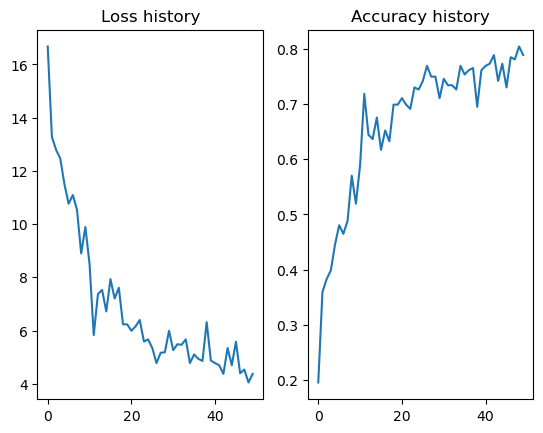

Test Accuracy: 0.7950000166893005


In [29]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"step: {step}, loss: {loss}, accuracy: {acc}")

plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss history')
plt.title('Loss history')
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy history')
plt.title('Accuracy history')
plt.show()

pred = neural_net(x_test)
print(f"Test Accuracy: {accuracy(pred, y_test)}")